# LangGraph Looping Logic

We'll showcase two distinct methods for implementing loops in LangGraph:

1. **Direct Conditional Routing**: Utilizing conditional edges straight from a processing node.
2. **Separate Decision Node**: Employing a dedicated node to handle routing decisions.


## Setup and Imports


In [ ]:
from langgraph.graph import StateGraph, END
import random
from typing import TypedDict, List
from IPython.display import Image, display
from rich import print

## Approach 1: Direct Conditional Routing

In this approach, we'll create a graph where the conditional edges are attached directly to the processing node. This creates a more compact graph structure.

### State Definition

We'll create a simple state that tracks a list of numbers and their running total. Our loop will continue adding random numbers until the total reaches a threshold.


In [46]:
# Define the shape of our state
class SumState(TypedDict):
    numbers: List[int]
    total: int

### Node Functions


In [47]:
# Entry node: initialize the list and total
def init_node(state: SumState) -> SumState:
    state["numbers"] = []
    state["total"] = 0
    return state


# Loop node: pick a random number, append it, and update the total
def add_number(state: SumState) -> SumState:
    num = random.randint(5, 15)
    state["numbers"].append(num)
    state["total"] += num
    return state


# Conditional function: decide whether to loop or exit
def check_continue(state: SumState) -> str:
    if state["total"] < 50:
        print(f"Total is {state['total']}, adding another number...")
        return "add"  # go back to the add_number node
    else:
        print(f"Reached total {state['total']}. Exiting loop.")
        return "end"  # jump to END

### Building the Graph

Now, we'll build the graph using direct conditional routing. Observe how the `add` node features conditional edges that can loop back to itself, forming a cycle.


In [48]:
# Build the graph
graph = StateGraph(SumState)

graph.add_node("init", init_node)
graph.add_node("add", add_number)

# From init → add
graph.add_edge("init", "add")

# From add → either add (loop) or END (using conditional routing)
graph.add_conditional_edges(
    "add",  # source node name
    check_continue,  # the decision function
    {
        "add": "add",  # loop back to the same node
        "end": END,  # or terminate the graph
    },
)

# Specify the starting node
graph.set_entry_point("init")

# Compile and run
app = graph.compile()

### Visualizing the Graph

Let's visualize the graph structure to understand the flow better.


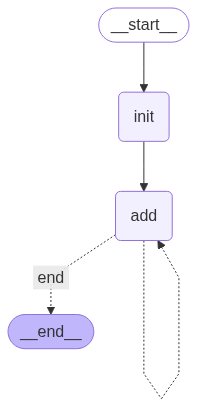

In [49]:
# Visualize the Graph (requires graphviz and pygraphviz or pydot)
display(Image(app.get_graph().draw_mermaid_png()))
# save the graph to a file
with open("./output//06.1-Looping_Logic.png", "wb") as f:
    f.write(app.get_graph().draw_mermaid_png())
# Mermaid is a popular diagramming syntax that can be rendered in many tools
with open("./output/06.1-Looping_Logic.mmd", "w") as f:
    f.write(app.get_graph().draw_mermaid())

### Running the Graph


In [50]:
final_state = app.invoke({"numbers": [], "total": 0})

print("\nFinal state:")
print(final_state)

Total is 6, adding another number...

Total is 13, adding another number...

Total is 28, adding another number...

Total is 40, adding another number...

Total is 48, adding another number...

Reached total 58. Exiting loop.

Final state:

{'numbers': [6, 7, 15, 12, 8, 10], 'total': 58}

## Approach 2: Separate Decision Node

In this approach, we'll use a dedicated decision node that acts as a router. This pattern separates the processing logic from the routing logic, which can be useful for more complex decision-making scenarios.

### Node Functions


In [51]:
# Entry node: initialize the list and total (same as before)
def init_node(state: SumState) -> SumState:
    state["numbers"] = []
    state["total"] = 0
    return state


# Loop node: pick a random number, append it, and update the total (same as before)
def add_number(state: SumState) -> SumState:
    num = random.randint(5, 15)
    state["numbers"].append(num)
    state["total"] += num
    return state


# Dummy pass-through node; real branching happens in the conditional edges
def start(state: SumState) -> SumState:
    return state


# Dummy pass-through node; real branching happens in the conditional edges
def decide_node(state: SumState) -> SumState:
    return state


# Conditional function: decide whether to loop or exit (same as before)
def check_continue(state: SumState) -> str:
    if state["total"] < 50:
        print(f"Total is {state['total']}, adding another number...")
        return "add"  # go back to add_number node
    else:
        print(f"Reached total {state['total']}. Exiting loop.")
        return "end"  # jump to END

### Building the Graph with Decision Node

This time we'll create a more explicit flow: `init → add → decide → (add or END)`


In [57]:
# Build the graph
graph = StateGraph(SumState)

graph.add_node("init", init_node)
graph.add_node("start", start)
graph.add_node("add", add_number)

graph.add_node("decide", decide_node)


# Wire up the flow: init → add → decide → (add or END)
graph.add_edge("init", "start")
graph.add_edge("start", "add")
graph.add_edge("add", "decide")

graph.add_conditional_edges(
    "decide",  # source node name
    check_continue,  # decision function
    {
        "add": "start",  # loop back to the add node
        "end": END,  # or terminate
    },
)

# Specify the starting node
graph.set_entry_point("init")

# Compile and run
app = graph.compile()


### Visualizing the Second Graph


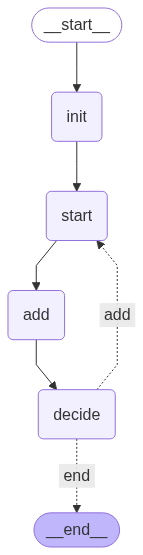

Total is 6, adding another number...

Total is 11, adding another number...

Total is 16, adding another number...

Total is 26, adding another number...

Total is 37, adding another number...

Total is 42, adding another number...

Reached total 54. Exiting loop.

Final state:

{'numbers': [6, 5, 5, 10, 11, 5, 12], 'total': 54}

In [58]:
display(Image(app.get_graph().draw_mermaid_png()))

with open("./output/06.2-Looping_Logic.png", "wb") as f:
    f.write(app.get_graph().draw_mermaid_png())

# save mermaid graph to a file
final_state = app.invoke({"numbers": [], "total": 0})
print("\nFinal state:")
print(final_state)

# Save the Mermaid representation of the graph
with open("./output/06.2-Looping_Logic.mmd", "w") as f:
    f.write(app.get_graph().draw_mermaid())

### Running the Second Graph


In [ ]:
final_state = app.invoke({"numbers": [], "total": 0})

print("\nFinal state:")
print(final_state)

Total is 14, adding another number...

Final state:

{'numbers': [14], 'total': 14}